# Healthcare Provider Segmentation Analysis

In this notebook, we will explore how to run a segmentation analysis on the providers to see if we can make meaningful groupings of providers.


In [1]:
# import necessary libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from functools import lru_cache
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering

In [2]:
# load the data
data = pd.read_excel('datos_ie.xlsx')
data.head(10)

,npi,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,tele_services_patients,total_patients,standard_services_claims_year,tele_services_claims_year,total_claims_year,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_claims,tele_services_psychotherapy_claims,total_psychotherapy_claims,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_claims_year,tele_services_psychotherapy_claims_year,total_psychotherapy_claims_year,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,NPI_Deactivation_Reason_Code,NPI_Deactivation_Date,NPI_Reactivation_Date,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,%psychotherapy_claims,%teleService_claims,%tele_psychotherapy_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,%psychotherapy_claims_year,%teleService_claims_year,%tele_psychotherapy_claims_year,%psychotherapy_patients_year,%stdService_patients_year,%teleService_patients_year,%tele_psychotherapy_patients_year,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_claims,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,Spoken_Language_Accessibility,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,working_hours_cleaned,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_claims,total_commercial_patients,total_medicare_claims,total_medicare_patients,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year
0,1,51,16.04,28348,2020,2,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,8,2,0,0,0,0,0,0,16,4
1,1,51,16.04,28348,2020,1,0,0,0,0,0,0,0,8,8,0,5,5,0,0,0,0,0,0,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0,0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,51,16.04,28348,2020,3,0,2,2,0,2,2,0,8,8,0,5,5,0,2,2,0,2,2,0,8,8,0,5,5,NaN,NaT,NaT,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,1.0,1.

# CLEANING/PRE-PROCESSING

The same procedure is carried out as when preparing the data for demand prediction modeling, except lagged variables are not created. 

In [3]:
# Cleaning the dataset 

# Read the content of the file
file_path = "specialization_dict.txt"

with open(file_path, "r") as file:
    dict_content = file.read()

specialization_dict = ast.literal_eval(dict_content)

In [4]:
# drop due to nulls 
data = data.drop(columns=["NPI_Deactivation_Reason_Code", "NPI_Deactivation_Date", "NPI_Reactivation_Date"])

In [5]:
# Trying to impute the null values in the 'Specialization_1' column, we analyze the common text in the corresponding values of the first and third columns; if any part of the common text matches any of the existing specializations, we replace the null value with it; otherwise, we add the common text 

df_null_specialization_1 = data[data['Specialization_1'].isnull()][['Classification_1', 'Specialization_1', 'Display_Name_1']]

@lru_cache(maxsize=None)
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for _ in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

unique_values = set(data['Specialization_1'].dropna().unique())

def common_substring(row):
    classification = str(row['Classification_1'])
    display_name = str(row['Display_Name_1'])
    common_string = longest_common_substring(classification, display_name)

    excluded_values = ['health', 'medical', 'registered', "children"]
    
    unique_values_matched = [value for value in unique_values
                             if value.lower() not in excluded_values
                             and value in common_string]
    if unique_values_matched:
        return ' '.join(unique_values_matched)  # if there are any matches within unique_values, we return them joined by a space
    else:
        return common_string  # else, we return the common_string itself

df_null_specialization_1['common_text'] = df_null_specialization_1.apply(common_substring, axis=1)

data_engineered = data.copy()

data_engineered.loc[df_null_specialization_1.index, 'Specialization_1'] = df_null_specialization_1['common_text']

unique_values_after_imputation = data_engineered['Specialization_1'].unique()

# Overview of the new specializations added
# Convert your arrays of unique values into sets
unique_values_after_imputation_set = set(unique_values_after_imputation)

# Get the new unique values after imputation by finding the set difference
new_unique_values = unique_values_after_imputation_set - unique_values

In [6]:
# In addition to combining different mental-health-related specializations, we look at the sorted number of total claims
# per specialization and the total mental-health-related claims vs. non-mental-health claims
# The phrases or string patterns we're looking for:
search_phrases = ["mental health", "psych", "professional", "counselor", "counseling", "addiction",
                  "community/behavioral health", "clinical neurophysiology", "neurodevelopmental disabilities",
                  "cognitive & behavioral", "behavior", "behavior technician", "rehabilitation, substance use disorder"]

# Initialize the lists for matching and non-matching values
matching_values = []
non_matching_values = []

# Iterate over all unique values
for value in unique_values_after_imputation:
    lower_value = str(value).lower()
    
    # Check if any of the phrases is in 'value'
    if any(phrase in lower_value for phrase in search_phrases):
        matching_values.append(value)
    else:
        non_matching_values.append(value)

# Add to matching_values where Classification_1 is Psychiatry & Neurology and not in exclude_specializations
more_matching_values = data_engineered[data_engineered['Classification_1'] == 'Psychiatry & Neurology']['Specialization_1'].unique()
matching_values.extend(more_matching_values)

non_matching_values = list(set(non_matching_values) - set(more_matching_values))

category_total_claims = {}
    
matching_sum = data_engineered[data_engineered['Specialization_1'].isin(matching_values)]['total_claims'].sum()
non_matching_sum = data_engineered[data_engineered['Specialization_1'].isin(non_matching_values)]['total_claims'].sum()

# Iterate over all matching values (mental health categories)
for category in matching_values:
    total_claims = data_engineered[data_engineered['Specialization_1'] == category]['total_claims'].sum()

    category_total_claims[category] = total_claims

sorted_category_total_claims = dict(sorted(category_total_claims.items(), key=lambda item: item[1], reverse=True))

data_engineered['mental_health'] = data_engineered['Specialization_1'].isin(matching_values).astype(int)

In [7]:
data_engineered['specialization_group'] = data_engineered['Specialization_1'].apply(lambda x: specialization_dict.get(x, 'mental_health'))

In [8]:
data_engineered['working_hours_owner_missing_info'] = (data_engineered['business_status'] == 'Info Not Available').astype(int)

In [9]:
data_engineered['business_status'] = data_engineered['business_status'].replace({
    'CLOSED_PERMANENTLY': 'CLOSED',
    'CLOSED_TEMPORARILY': 'CLOSED'})

In [10]:
data_engineered['Weekend Availability'] = data_engineered['Weekend Availability'].replace({
    'Only Saturday': 'Partially',
    'Only Sunday': 'Partially'})

In [11]:
data_engineered['minority_owned'] = data_engineered['owner_identification'].apply(
    lambda x: 0 if x == 'Info Not Available' else 1
)

In [12]:
data_engineered['extra_languages_spoken'] = data_engineered.apply(
    lambda row: row['Spoken_Language_Accessibility'] - 1 if row['EN_English'] == 1 else row['Spoken_Language_Accessibility'], 
    axis=1
)

data_engineered['extra_languages_spoken'] = data_engineered['extra_languages_spoken'].replace(23, 0)

data_engineered.drop(columns=['Spoken_Language_Accessibility'], inplace=True)

In [13]:
# Create grouped dataframes
provider_group = data_engineered.groupby('npi')
county_group = data_engineered.groupby('countyID')

# Get the number of providers per county for each year
providers_per_county_year = data_engineered.groupby(['countyID', 'service_year'])['npi'].nunique()

# This is a multi-index series (i.e., series with multiple indices: countyID and Year)
# So we will reset its index to make it a DataFrame, making it easier to merge with the original data
providers_per_county_year = providers_per_county_year.reset_index()
providers_per_county_year.rename(columns={'npi': 'providers_per_county'}, inplace=True)

# Merge this DataFrame with the original data to get the providers per county for the respective year in each record
data_engineered = pd.merge(data_engineered, providers_per_county_year, on=['countyID', 'service_year'], how='left')

In [14]:
data_engineered['year_quarter'] = data_engineered['service_year'].astype(str) + ' Q' + data_engineered['service_quarter'].astype(str) # to enable sorting
data_engineered = data_engineered.sort_values(by=['npi', 'year_quarter'])
data_engineered.drop(columns=['year_quarter'], inplace=True) # not needed any longer

# END OF CLEANING/PRE-PROCESSING

We want the supply segmentation to be "up to date". Hence, we will focus on the observations in the dataset relating to the recent year, i.e., 2020.

In [15]:
df2020 = data_engineered[(data_engineered['service_year'] == 2020)].copy() # filter df for 2020 observations only

In [16]:
# NPIs from data_engineered and df2020
npis_all = set(data_engineered['npi'])
npis_2020 = set(df2020['npi'])

# NPIs that are in data_engineered but not in df2020
npi_not_in_2020 = npis_all - npis_2020

print('Total unique NPIs in dataset with observations in 2020:', len(npis_2020))
print('Total unique NPIs in dataset:', len(npis_all))
print('NPIs not recorded/active in 2020:', len(npi_not_in_2020)) 

Total unique NPIs in dataset with observations in 2020: 8920
Total unique NPIs in dataset: 11383
NPIs not recorded/active in 2020: 2463


The NPIs not recorded/active in 2020 will make up a "not active" cluster. The remaining NPIs will be clustered using an unsupervised learning algorithm.

In [17]:
# exploring columns
col_list = list(df2020.columns)
col_list

['npi',
 'countyID',
 'census_tract',
 'zip5',
 'service_year',
 'service_quarter',
 'standard_services_claims',
 'tele_services_claims',
 'total_claims',
 'standard_services_patients',
 'tele_services_patients',
 'total_patients',
 'standard_services_claims_year',
 'tele_services_claims_year',
 'total_claims_year',
 'standard_services_patients_year',
 'tele_services_patients_year',
 'total_patients_year',
 'standard_services_psychotherapy_claims',
 'tele_services_psychotherapy_claims',
 'total_psychotherapy_claims',
 'standard_services_psychotherapy_patients',
 'tele_services_psychotherapy_patients',
 'total_psychotherapy_patients',
 'standard_services_psychotherapy_claims_year',
 'tele_services_psychotherapy_claims_year',
 'total_psychotherapy_claims_year',
 'standard_services_psychotherapy_patients_year',
 'tele_services_psychotherapy_patients_year',
 'total_psychotherapy_patients_year',
 'Healthcare_Provider_Taxonomy_Code_1',
 'Grouping_1',
 'Classification_1',
 'Specialization_1',

We need to group the dataset by NPI. Hence, we define which aggregation function to use for each feature. 

In [18]:
# Define aggregation functions for each column

agg_funcs = {
    'countyID': 'last', 
    'census_tract': 'last',
    'zip5': 'last',
    'service_year': 'last',
    'service_quarter': 'last',
    'standard_services_claims': 'mean',
    'tele_services_claims': 'mean',
    'total_claims': 'mean',
    'standard_services_patients': 'mean',
    'tele_services_patients': 'mean',
    'total_patients': 'mean',
    'standard_services_claims_year': 'last',
    'tele_services_claims_year': 'last',
    'total_claims_year': 'last',
    'standard_services_patients_year': 'last',
    'tele_services_patients_year': 'last',
    'total_patients_year': 'last',
    'standard_services_psychotherapy_claims': 'mean',
    'tele_services_psychotherapy_claims': 'mean',
    'total_psychotherapy_claims': 'mean',
    'standard_services_psychotherapy_patients': 'mean',
    'tele_services_psychotherapy_patients': 'mean',
    'total_psychotherapy_patients': 'mean',
    'standard_services_psychotherapy_claims_year': 'last',
    'tele_services_psychotherapy_claims_year': 'last',
    'total_psychotherapy_claims_year': 'last',
    'standard_services_psychotherapy_patients_year': 'last',
    'tele_services_psychotherapy_patients_year': 'last',
    'total_psychotherapy_patients_year': 'last',
    'Healthcare_Provider_Taxonomy_Code_1': 'last',
    'Grouping_1': 'last',
    'Classification_1': 'last',
    'Specialization_1': 'last',
    'Display_Name_1': 'last',
    '%psychotherapy_claims': 'mean',
    '%teleService_claims': 'mean',
    '%tele_psychotherapy_claims': 'mean',
    '%psychotherapy_patients': 'mean',
    '%stdService_patients': 'mean',
    '%teleService_patients': 'mean',
    '%tele_psychotherapy_patients': 'mean',
    '%psychotherapy_claims_year': 'mean',
    '%teleService_claims_year': 'mean',
    '%tele_psychotherapy_claims_year': 'mean',
    '%psychotherapy_patients_year': 'mean',
    '%stdService_patients_year': 'mean',
    '%teleService_patients_year': 'mean',
    '%tele_psychotherapy_patients_year': 'mean',
    'psychotherapy_provider_through_taxonomy': 'last',
    'provided_psychotherapy': 'last',
    'psychotherapy_provider': 'last',
    'countyname': 'last',
    'urbanity': 'last',
    'lat': 'last',
    'long': 'last',
    'transport_access': 'last',
    'broadband_access': 'last',
    'total_medicaid_claims': 'mean',
    'total_medicaid_patients': 'mean',
    'provider_size': 'last',
    'Entity_Type_Code': 'last',
    'AH_Sign language services for the deaf and hard of hearing': 'last',
    'EN_English': 'last',
    'SP_Spanish': 'last',
    'NX_American Indian or Alaska Native languages': 'last',
    'FX_Other languages (excluding Spanish)': 'last',
    'F4_Arabic': 'last',
    'F17_Any Chinese Language': 'last',
    'F19_Creole': 'last',
    'F25_Farsi': 'last',
    'F28_French': 'last',
    'F30_German': 'last',
    'F31_Greek': 'last',
    'F35_Hebrew': 'last',
    'F36_Hindi': 'last',
    'F37_Hmong': 'last',
    'F42_Italian': 'last',
    'F43_Japanese': 'last',
    'F47_Korean': 'last',
    'F66_Polish': 'last',
    'F67_Portuguese': 'last',
    'F70_Russian': 'last',
    'F81_Tagalog': 'last',
    'F92_Vietnamese': 'last',
    'N24_Ojibwa': 'last',
    'N40_Yupik': 'last',
    'black_owned': 'last',
    'latino_owned': 'last',
    'lgbtq+_owned': 'last',
    'veteran_owned': 'last',
    'women_owned': 'last',
    'owner_identification': 'last',
    'planning_accepts_new_patients': 'last',
    'business_status': 'last',
    'working_hours_cleaned': 'last',
    'Weekend Availability': 'last',
    'Availability Before 8AM': 'last',
    'Availability After 5PM': 'last',
    'total_commercial_claims': 'mean',
    'total_commercial_patients': 'mean',
    'total_medicare_claims': 'mean',
    'total_medicare_patients': 'mean',
    'total_other_payers_claims': 'mean',
    'total_other_payers_patients': 'mean',
    'total_commercial_claims_year': 'mean',
    'total_commercial_patients_year': 'mean',
    'total_medicaid_claims_year': 'mean',
    'total_medicaid_patients_year': 'mean',
    'total_medicare_claims_year': 'mean',
    'total_medicare_patients_year': 'mean',
    'total_other_payers_claims_year': 'mean',
    'total_other_payers_patients_year': 'mean',
     'mental_health': 'last', 
     'specialization_group': 'last',
     'working_hours_owner_missing_info': 'last', 
     'minority_owned': 'last',
     'extra_languages_spoken': 'last',
     'providers_per_county': 'mean'
}

# Aggregate the data
df_aggregated = df2020.groupby('npi').agg(agg_funcs) # keeping NPI as index to enable mapping to demand prediction
df_aggregated.head()

,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,tele_services_patients,total_patients,standard_services_claims_year,tele_services_claims_year,total_claims_year,standard_services_patients_year,tele_services_patients_year,total_patients_year,standard_services_psychotherapy_claims,tele_services_psychotherapy_claims,total_psychotherapy_claims,standard_services_psychotherapy_patients,tele_services_psychotherapy_patients,total_psychotherapy_patients,standard_services_psychotherapy_claims_year,tele_services_psychotherapy_claims_year,total_psychotherapy_claims_year,standard_services_psychotherapy_patients_year,tele_services_psychotherapy_patients_year,total_psychotherapy_patients_year,Healthcare_Provider_Taxonomy_Code_1,Grouping_1,Classification_1,Specialization_1,Display_Name_1,%psychotherapy_claims,%teleService_claims,%tele_psychotherapy_claims,%psychotherapy_patients,%stdService_patients,%teleService_patients,%tele_psychotherapy_patients,%psychotherapy_claims_year,%teleService_claims_year,%tele_psychotherapy_claims_year,%psychotherapy_patients_year,%stdService_patients_year,%teleService_patients_year,%tele_psychotherapy_patients_year,psychotherapy_provider_through_taxonomy,provided_psychotherapy,psychotherapy_provider,countyname,urbanity,lat,long,transport_access,broadband_access,total_medicaid_claims,total_medicaid_patients,provider_size,Entity_Type_Code,AH_Sign language services for the deaf and hard of hearing,EN_English,SP_Spanish,NX_American Indian or Alaska Native languages,FX_Other languages (excluding Spanish),F4_Arabic,F17_Any Chinese Language,F19_Creole,F25_Farsi,F28_French,F30_German,F31_Greek,F35_Hebrew,F36_Hindi,F37_Hmong,F42_Italian,F43_Japanese,F47_Korean,F66_Polish,F67_Portuguese,F70_Russian,F81_Tagalog,F92_Vietnamese,N24_Ojibwa,N40_Yupik,black_owned,latino_owned,lgbtq+_owned,veteran_owned,women_owned,owner_identification,planning_accepts_new_patients,business_status,working_hours_cleaned,Weekend Availability,Availability Before 8AM,Availability After 5PM,total_commercial_claims,total_commercial_patients,total_medicare_claims,total_medicare_patients,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year,mental_health,specialization_group,working_hours_owner_missing_info,minority_owned,extra_languages_spoken,providers_per_county
npi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,16.04,28348,2020,4,0.00,2.00,2.00,0.00,1.50,1.50,0,8,8,0,5,5,0.00,2.00,2.00,0.00,1.50,1.50,0,8,8,0,5,5,101YA0400X,Behavioral Health & Social Service Providers,Counselor,Addiction (Substance Use Disorder),Addiction (Substance Use Disorder) Counselor,0.500,0.5000,0.500,0.50,0.000,0.500,0.500,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1,1,1,Cumberland,Urban,34.985025,-78.916585,0.900,0.89,0.0,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,Info Not Available,Info Not Available,Info Not Available,Info Not Available,Info Not Available,0.0,0.0,0.0,0.0,2.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.00,1,mental_health,1,0,0,461.0
2,71,328.00,28052,2020,4,0.00,3.00,3.00,0.00,0.50,0.50,0,12,12,0,1,1,0.00,3.00,3.00,0.00,0.50,0.50,0,12,12,0,1,1,1041C0700X,Behavioral Health & Social Service Providers,Social Worker,Clinical,Clinical Social Worker,0.500,0.5000,0.500,0.50,0.000,0.500,0.500,1.0,1.00,1.0,1.0,0.0,1.0,1.0,1,1,1,Gaston,Urban,35.258674,-81.180363,0.697,0.26,0.0,0.0,Small,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Info Not Available,0,OPERATIONAL,Info Not Available,No,No,No,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,Multi-Specialty Groups and Organizations,0,0,0,139.0
3,81,153.02,27377,2020,

In [19]:
df_aggregated.shape

(8920, 118)

In [20]:
# exploring the language-related columns

language_columns = ['AH_Sign language services for the deaf and hard of hearing',
       'EN_English', 'SP_Spanish',
       'NX_American Indian or Alaska Native languages',
       'FX_Other languages (excluding Spanish)', 'F4_Arabic',
       'F17_Any Chinese Language', 'F19_Creole', 'F25_Farsi', 'F28_French',
       'F30_German', 'F31_Greek', 'F35_Hebrew', 'F36_Hindi', 'F37_Hmong',
       'F42_Italian', 'F43_Japanese', 'F47_Korean', 'F66_Polish',
       'F67_Portuguese', 'F70_Russian', 'F81_Tagalog', 'F92_Vietnamese',
       'N24_Ojibwa', 'N40_Yupik', 'extra_languages_spoken']

# Checking for value counts of language columns
for col in language_columns:
    print(df_aggregated[col].value_counts())
    print('______________________________________________________')

AH_Sign language services for the deaf and hard of hearing
0    8849
1      71
Name: count, dtype: int64
______________________________________________________
EN_English
0    8889
1      31
Name: count, dtype: int64
______________________________________________________
SP_Spanish
0    8844
1      76
Name: count, dtype: int64
______________________________________________________
NX_American Indian or Alaska Native languages
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
FX_Other languages (excluding Spanish)
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F4_Arabic
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F17_Any Chinese Language
0    8856
1      64
Name: count, dtype: int64
______________________________________________________
F19_Creole
0    8856
1      64
Name: count, dtype: int64
___________________________________

The language-related columns have very few "True" observations across the different languages. Hence, the individual language features are likely not meaningful to use for clustering.

In [21]:
# checking for nulls
for col in df_aggregated.columns:
    print(col, df_aggregated[col].isnull().sum())
    print('______________________________________________________')

countyID 0
______________________________________________________
census_tract 0
______________________________________________________
zip5 0
______________________________________________________
service_year 0
______________________________________________________
service_quarter 0
______________________________________________________
standard_services_claims 0
______________________________________________________
tele_services_claims 0
______________________________________________________
total_claims 0
______________________________________________________
standard_services_patients 0
______________________________________________________
tele_services_patients 0
______________________________________________________
total_patients 0
______________________________________________________
standard_services_claims_year 0
______________________________________________________
tele_services_claims_year 0
______________________________________________________
total_claims_year 0
___

In [22]:
# identifying boolean features
# if the only values are 0 and 1 for a column, put the type of the col to boolean 
for col in df_aggregated.columns:
    if list(df_aggregated[col].unique()) in [[0, 1], [1, 0]]:
        df_aggregated[col] = df_aggregated[col].astype(bool)

In [23]:
# checking data types
for col in df_aggregated.columns:
    # print col and dtype
    print(col, df_aggregated[col].dtype)
    print('______________________________________________________')

countyID int64
______________________________________________________
census_tract float64
______________________________________________________
zip5 int64
______________________________________________________
service_year int64
______________________________________________________
service_quarter int64
______________________________________________________
standard_services_claims float64
______________________________________________________
tele_services_claims float64
______________________________________________________
total_claims float64
______________________________________________________
standard_services_patients float64
______________________________________________________
tele_services_patients float64
______________________________________________________
total_patients float64
______________________________________________________
standard_services_claims_year int64
______________________________________________________
tele_services_claims_year int64
____________

# Feature selection

In [198]:
# Considering which columns are significant for clustering 
cols = list(df_aggregated.columns)
cols

['countyID',
 'census_tract',
 'zip5',
 'service_year',
 'service_quarter',
 'standard_services_claims',
 'tele_services_claims',
 'total_claims',
 'standard_services_patients',
 'tele_services_patients',
 'total_patients',
 'standard_services_claims_year',
 'tele_services_claims_year',
 'total_claims_year',
 'standard_services_patients_year',
 'tele_services_patients_year',
 'total_patients_year',
 'standard_services_psychotherapy_claims',
 'tele_services_psychotherapy_claims',
 'total_psychotherapy_claims',
 'standard_services_psychotherapy_patients',
 'tele_services_psychotherapy_patients',
 'total_psychotherapy_patients',
 'standard_services_psychotherapy_claims_year',
 'tele_services_psychotherapy_claims_year',
 'total_psychotherapy_claims_year',
 'standard_services_psychotherapy_patients_year',
 'tele_services_psychotherapy_patients_year',
 'total_psychotherapy_patients_year',
 'Healthcare_Provider_Taxonomy_Code_1',
 'Grouping_1',
 'Classification_1',
 'Specialization_1',
 'Displ

In [319]:
# columns for clustering

cluster_columns = [
    #'total_claims',
    #'standard_services_claims',
    #'tele_services_claims',
    #'total_psychotherapy_claims',
    #'Grouping_1',
    #'Classification_1',
    #'Specialization_1',
    '%psychotherapy_patients',
    '%stdService_patients',
    '%teleService_patients',
    #'%tele_psychotherapy_patients',
    'psychotherapy_provider_through_taxonomy',
    'urbanity', 
    'transport_access',
    'broadband_access',
    'provider_size',
    'planning_accepts_new_patients',
    'business_status',
    'Weekend Availability',
    'Availability Before 8AM',
    'Availability After 5PM',
    #'total_medicaid_claims',
    #'total_commercial_claims',
    #'total_medicare_claims',
    #'total_other_payers_claims',
    'mental_health',
    'specialization_group',
    'working_hours_owner_missing_info',
    'minority_owned',
    'extra_languages_spoken',
    'providers_per_county'
]

In [320]:
df_final = df_aggregated[cluster_columns] # df to train clustering algorithm

In [321]:
df_final.head()

,%psychotherapy_patients,%stdService_patients,%teleService_patients,psychotherapy_provider_through_taxonomy,urbanity,transport_access,broadband_access,provider_size,planning_accepts_new_patients,business_status,Weekend Availability,Availability Before 8AM,Availability After 5PM,mental_health,specialization_group,working_hours_owner_missing_info,minority_owned,extra_languages_spoken,providers_per_county
npi,,,,,,,,,,,,,,,,,,,
1,0.50,0.000,0.500,True,Urban,0.900,0.89,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,461.0
2,0.50,0.000,0.500,True,Urban,0.697,0.26,Small,False,OPERATIONAL,No,No,No,False,Multi-Specialty Groups and Organizations,False,False,0,139.0
3,0.25,0.125,0.125,False,Urban,1.000,0.60,Small,True,OPERATIONAL,No,No,No,False,Specialized and Allied Health Services,False,False,0,400.0
4,0.25,0.250,0.000,True,Urban,0.985,0.53,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,1402.0
5,0.25,0.000,0.250,True,Urban,0.895,0.87,Small,False,Info Not Available,Info Not Available,Info Not Available,Info Not Available,True,mental_health,True,False,0,829.0


# Scaling

In [322]:
# Extract features data
X = df_final.copy()

# Standardize the data
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# encoding categorical columns
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[categorical_columns]).toarray()

# scaling numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_columns])

# Concatenate the encoded categorical columns and the scaled numerical columns
X_final = np.concatenate([X_encoded, X_scaled], axis=1)
X_final.shape

(8920, 37)

In [323]:
# converting X_final to df 
X_final_df = pd.DataFrame(X_final, columns = list(encoder.get_feature_names_out()) + list(numeric_columns))
cluster_df = X_final_df.copy() # creating copy to store clusters
X_final_df.head()

,psychotherapy_provider_through_taxonomy_True,urbanity_Urban,provider_size_Small,planning_accepts_new_patients_True,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_True,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_True,minority_owned_True,%psychotherapy_patients,%stdService_patients,%teleService_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.114316,-1.519480,0.453265,-0.430110,0.738582,-0.040051,-0.138126
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.114316,-1.519480,0.453265,-3.187552,-2.933029,-0.040051,-0.838561
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.811732,-1.071334,-1.003881,0.928236,-0.951525,-0.040051,-0.270817
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.811732,-0.623188,-1.489596,0.724484,-1.359481,-0.040051,1.908796
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.811732,-1.519480,-0.518165,-0.498027,0.622023,-0.040051,0.662371


In [324]:
# checking where nan values and seeing whole output 
X_final_df.isnull().sum().sort_values(ascending=False).head(5)

psychotherapy_provider_through_taxonomy_True                  0
specialization_group_Pediatrics                               0
specialization_group_Primary Care and General Practice        0
specialization_group_Public Health and Preventive Medicine    0
specialization_group_Rehabilitation and Therapy               0
dtype: int64

In [325]:
# checking for nonetype 
X_final_df.dtypes

psychotherapy_provider_through_taxonomy_True                     float64
urbanity_Urban                                                   float64
provider_size_Small                                              float64
planning_accepts_new_patients_True                               float64
business_status_Info Not Available                               float64
business_status_OPERATIONAL                                      float64
Weekend Availability_No                                          float64
Weekend Availability_Partially                                   float64
Weekend Availability_Yes                                         float64
Availability Before 8AM_No                                       float64
Availability Before 8AM_Yes                                      float64
Availability After 5PM_No                                        float64
Availability After 5PM_Yes                                       float64
mental_health_True                                 

# K-means clustering

Number of clusters: 2, Silhouette Score: 0.17197171516559442, Inertia: 74423.14742443354
Number of clusters: 3, Silhouette Score: 0.1968975790775389, Inertia: 64810.50008973548
Number of clusters: 4, Silhouette Score: 0.19920184260509138, Inertia: 56808.405273400334
Number of clusters: 5, Silhouette Score: 0.19300588870065974, Inertia: 49835.33872202332
Number of clusters: 6, Silhouette Score: 0.19251129250730453, Inertia: 46093.44909060784
Number of clusters: 7, Silhouette Score: 0.19253793521031184, Inertia: 42580.37146790853
Number of clusters: 8, Silhouette Score: 0.18314329632173637, Inertia: 40298.588859611744
Number of clusters: 9, Silhouette Score: 0.1817202732406819, Inertia: 38443.7562045582
Number of clusters: 10, Silhouette Score: 0.16649820945566557, Inertia: 37030.7034160622
Number of clusters: 11, Silhouette Score: 0.19026196091157435, Inertia: 35721.05461941793
Number of clusters: 12, Silhouette Score: 0.17104010366347883, Inertia: 34404.840998683874
Number of clusters:

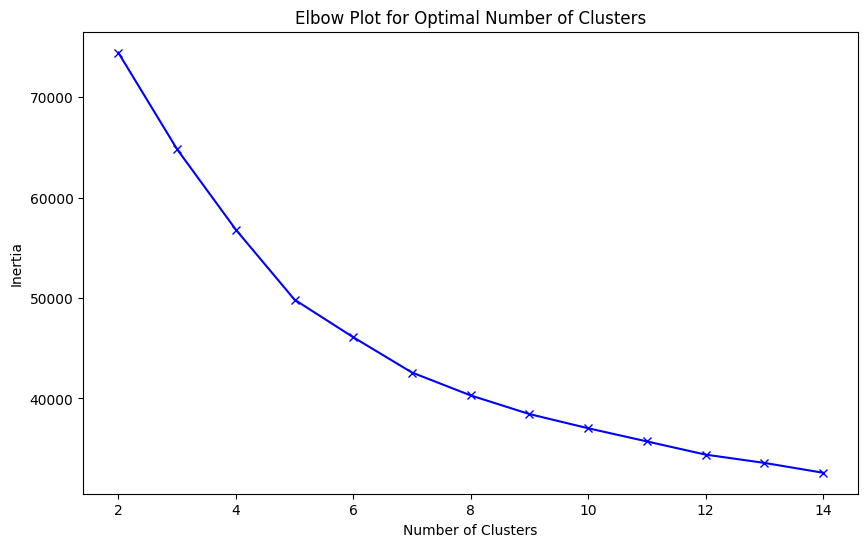

Best number of clusters: 4, Best Silhouette Score: 0.19920184260509138


In [326]:
# Define a function to evaluate K-Means with different numbers of clusters using both inertia and silhouette score
def evaluate_kmeans(X, n_clusters_list):
    best_n_clusters = None
    best_silhouette = -1
    silhouette_scores = []
    inertia_values = []
    
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=8)
        labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        inertia = kmeans.inertia_
        
        silhouette_scores.append(silhouette_avg)
        inertia_values.append(inertia)
        
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}, Inertia: {inertia}')
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_clusters = n_clusters
    
    # Plot the elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_list, inertia_values, 'bx-') 
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot for Optimal Number of Clusters')
    plt.show()
    
    return best_n_clusters, best_silhouette

# Evaluate K-Means with different numbers of clusters
n_clusters_list = range(2, 15)
X_final = X_final_df.to_numpy()
best_n_clusters, best_silhouette = evaluate_kmeans(X_final, n_clusters_list)

print(f'Best number of clusters: {best_n_clusters}, Best Silhouette Score: {best_silhouette}')

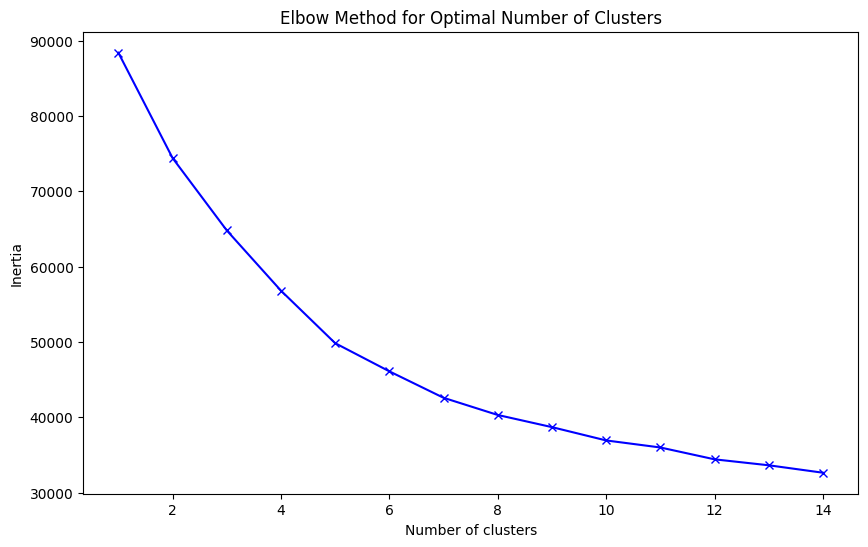

In [327]:
# same as above, just quicker to run
# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 15)
# cast df back to numpy array 
X_final = X_final_df.to_numpy()
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [328]:
# Fit K-means with the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_df['kmeans_cluster'] = kmeans.fit_predict(X_final)

# checking the clusters
cluster_df['kmeans_cluster'].value_counts().sort_index()

kmeans_cluster
0    2468
1     527
2    2958
3    2951
4      16
Name: count, dtype: int64

In [329]:
cluster_df.groupby('kmeans_cluster').mean()

,psychotherapy_provider_through_taxonomy_True,urbanity_Urban,provider_size_Small,planning_accepts_new_patients_True,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_True,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_True,minority_owned_True,%psychotherapy_patients,%stdService_patients,%teleService_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.367504,0.856159,0.990681,0.567666,0.000000,0.929903,0.916937,0.035656,0.047407,0.931524,0.068476,0.850891,0.149109,0.292950,0.014182,0.043355,0.066451,0.000810,0.166937,0.132901,0.010940,0.222447,0.001216,0.002836,0.010130,0.008509,0.015397,0.292950,0.000000,0.018233,-0.433216,0.339257,-0.444621,0.319011,0.059158,-0.040051,-0.091108
1,0.519924,0.874763,0.994307,0.182163,0.677419,0.307400,0.296015,0.015180,0.011385,0.313093,0.009488,0.280835,0.041746,0.349146,0.017078,0.015180,0.060721,0.000000,0.248577,0.081594,0.018975,0.155598,0.000000,0.007590,0.013283,0.003795,0.011385,0.349146,0.677419,0.007590,-0.051318,0.115793,-0.006651,-3.164277,-2.899079,-0.040051,0.158506
2,0.523665,0.871535,0.994591,0.000000,0.998986,0.000338,0.000000,0.000338,0.000676,0.000000,0.001014,0.000000,0.001014,0.355308,0.022650,0.023665,0.037187,0.000676,0.234618,0.059500,0.012847,0.201826,0.001352,0.003381,0.013523,0.006761,0.010142,0.355308,0.998986,0.000000,-0.592890,0.208636,-0.660115,0.349777,0.080918,-0.040051,0.000101
3,0.912572,0.894951,0.983057,0.069129,0.843104,0.143680,0.141647,0.011522,0.003728,0.154185,0.002711,0.119620,0.037275,0.550661,0.000000,0.002711,0.003050,0.000000,0.348018,0.014910,0.001017,0.049475,0.002033,0.002033,0.000678,0.000000,0.000339,0.550661,0.843104,0.009827,0.965030,-0.512006,1.032944,-0.052107,0.384995,-0.040051,0.045896
4,0.500000,0.937500,0.875000,0.875000,0.000000,1.000000,0.750000,0.062500,0.187500,0.875000,0.125000,0.437500,0.562500,0.687500,0.000000,0.000000,0.125000,0.000000,0.062500,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.687500,0.000000,0.312500,0.136780,-0.282765,0.327162,-0.038736,0.396190,22.288548,0.348861


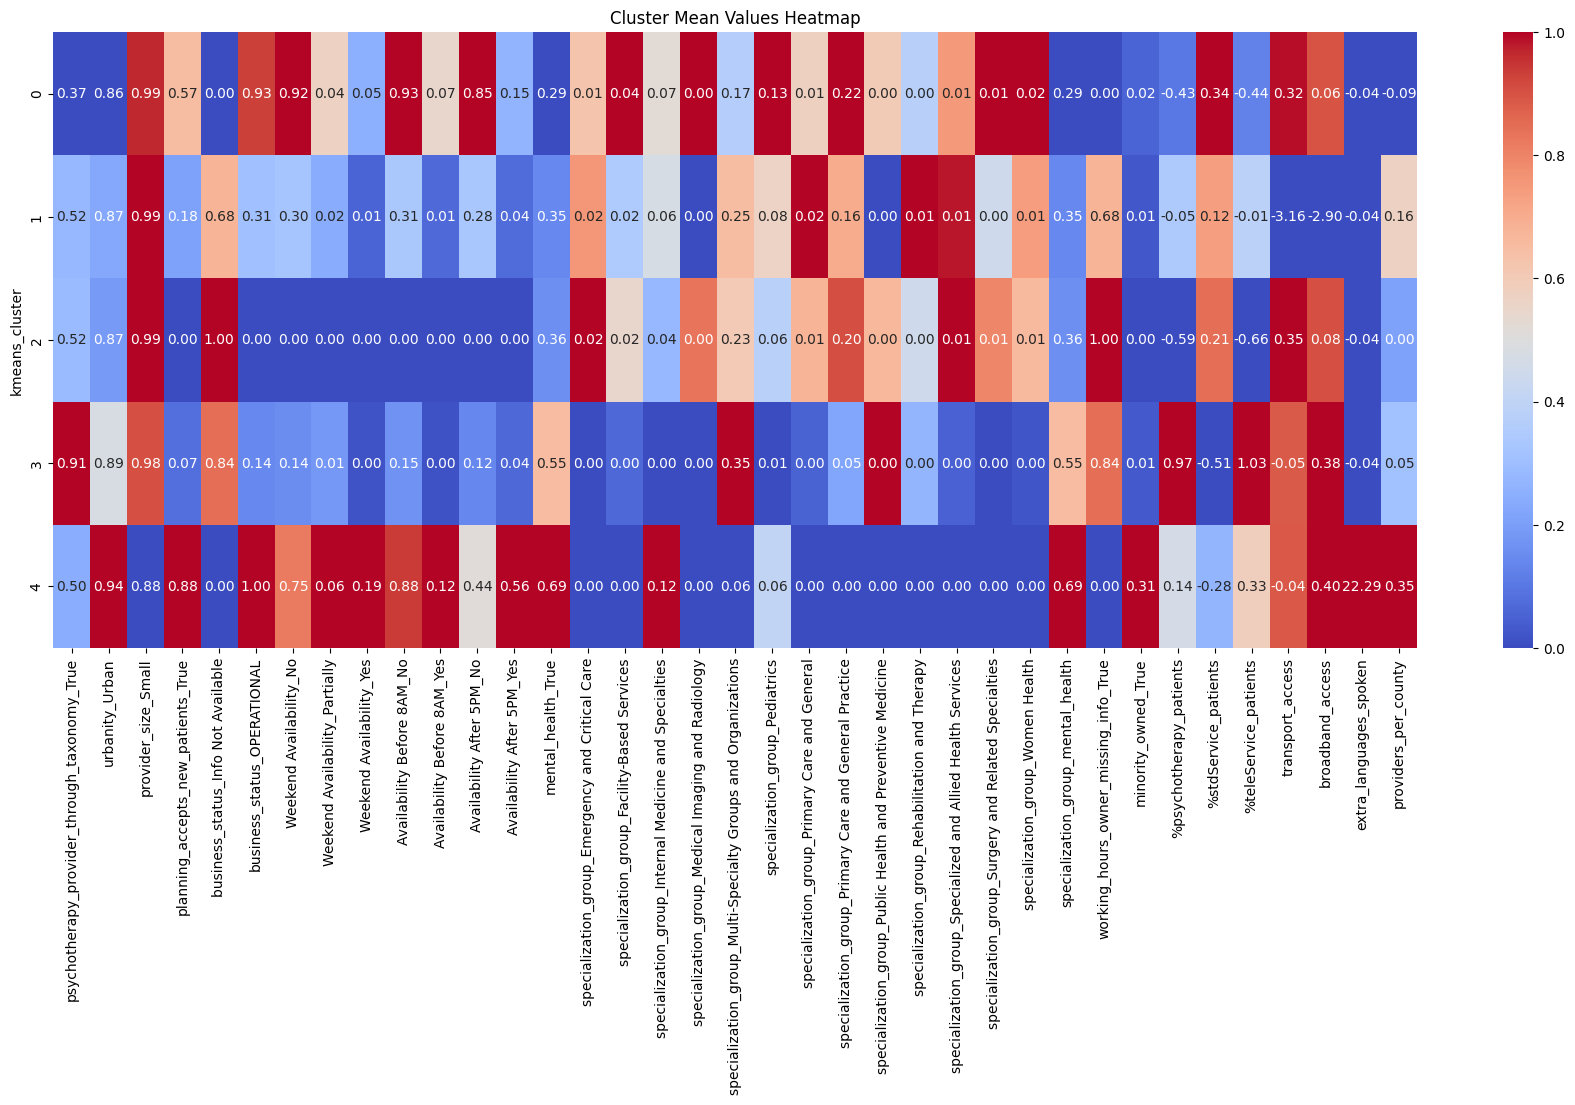

In [343]:
# plotting the above as a heatmap
grouped_means = cluster_df.groupby('kmeans_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(grouped_means)
normalized_df = pd.DataFrame(normalized_data, index=grouped_means.index, columns=grouped_means.columns)

# the heatmap is colored based on the normalized data but it is the "original" mean values that are shown
plt.figure(figsize=(22, 8))
sns.heatmap(normalized_df, cmap='coolwarm', annot=grouped_means, fmt=".2f")
plt.title('Cluster Mean Values Heatmap')
plt.show()

In [330]:
mean_values_per_cluster = cluster_df.groupby('kmeans_cluster').mean()

# Loop through each cluster
for cluster, features in mean_values_per_cluster.iterrows():
    print(f'Cluster {cluster}:')
    for feature, mean_value in features.items():
        print(f'  {feature}: {mean_value}')

Cluster 0:
  psychotherapy_provider_through_taxonomy_True: 0.3675040518638574
  urbanity_Urban: 0.8561588330632091
  provider_size_Small: 0.9906807131280388
  planning_accepts_new_patients_True: 0.5676661264181524
  business_status_Info Not Available: 0.0
  business_status_OPERATIONAL: 0.929902755267423
  Weekend Availability_No: 0.916936790923825
  Weekend Availability_Partially: 0.03565640194489465
  Weekend Availability_Yes: 0.04740680713128039
  Availability Before 8AM_No: 0.9315235008103727
  Availability Before 8AM_Yes: 0.06847649918962723
  Availability After 5PM_No: 0.8508914100486223
  Availability After 5PM_Yes: 0.14910858995137763
  mental_health_True: 0.29294975688816854
  specialization_group_Emergency and Critical Care: 0.014181523500810372
  specialization_group_Facility-Based Services: 0.043354943273905995
  specialization_group_Internal Medicine and Specialties: 0.06645056726094004
  specialization_group_Medical Imaging and Radiology: 0.0008103727714748784
  specializa

Random Forest Classifier Accuracy: 0.97847533632287
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       631
           1       1.00      0.98      0.99       116
           2       0.98      0.99      0.98       722
           3       0.98      0.96      0.97       756
           4       1.00      0.40      0.57         5

    accuracy                           0.98      2230
   macro avg       0.99      0.86      0.90      2230
weighted avg       0.98      0.98      0.98      2230



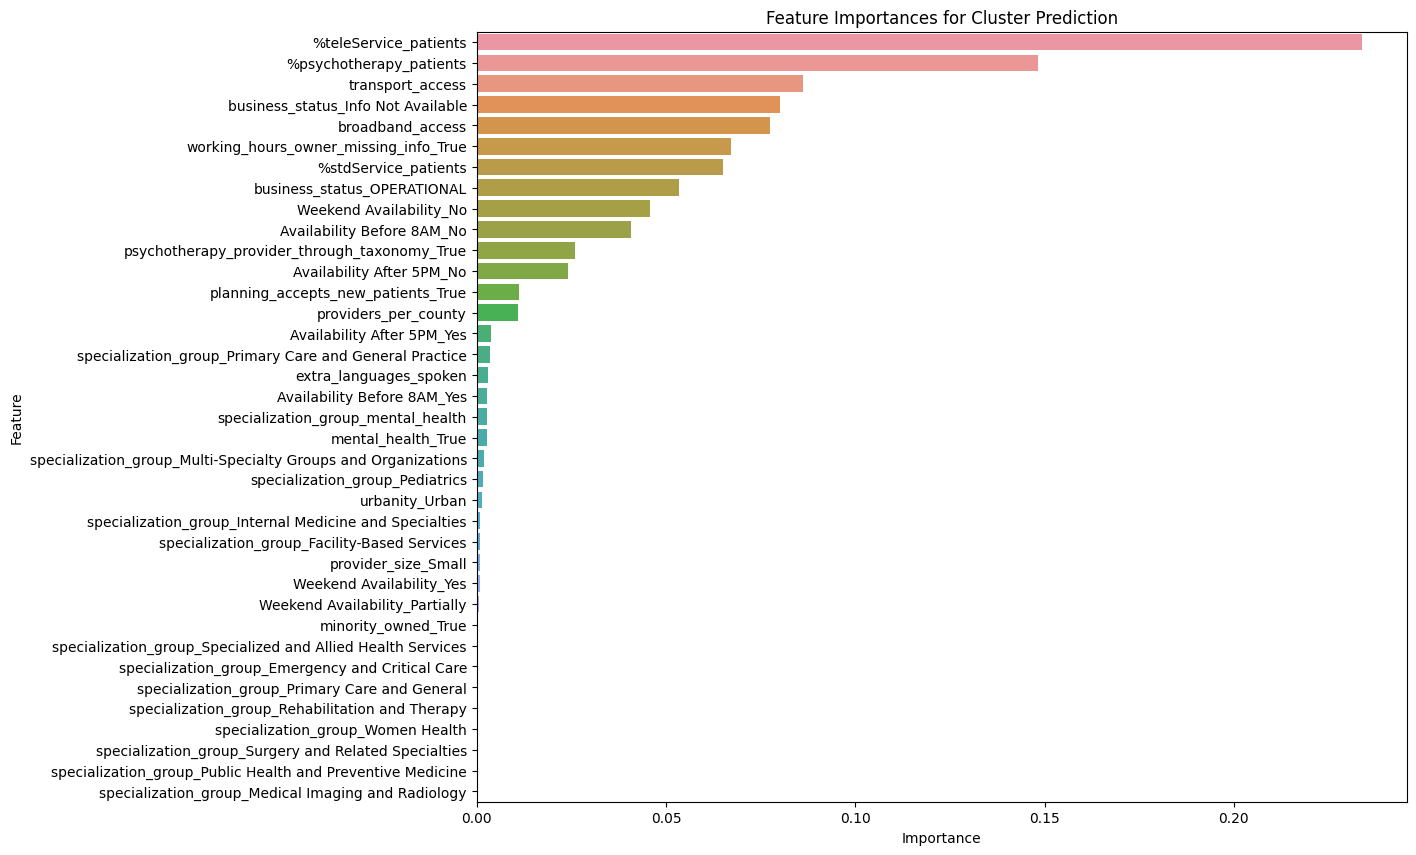

In [331]:
# creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering
# additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, cluster_df['kmeans_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_final_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

In [332]:
# to check the robustness of the clustering, we use adjusted_rand_score 

# Split the data into two halves
X1, X2 = train_test_split(X_final, test_size=0.5, random_state=42)

# Perform clustering on both halves
kmeans1 = KMeans(n_clusters=optimal_k, n_init=10, random_state=42).fit(X1)
kmeans2 = KMeans(n_clusters=optimal_k, n_init=10, random_state=42).fit(X2)

# Compare the clustering results
ari = adjusted_rand_score(kmeans1.labels_, kmeans2.predict(X1))

print(f'Adjusted Rand Index: {ari}')

Adjusted Rand Index: 0.7656449765155542


- ARI ranges from -1 to 1
    - 1: Perfect agreement between the two clusterings (i.e., the two clusterings are identical).
    - 0: The clustering results are no better than random assignments.
    - Negative values: Indicate that the agreement is worse than random assignments (rare in practice).

In [316]:
cluster_df = cluster_df.drop(columns='kmeans_cluster')

# Agglomerative Clustering

In [333]:
# Fit Agglomerative Clustering with the optimal number of clusters
agg = AgglomerativeClustering(n_clusters=optimal_k)
cluster_df['agg_cluster'] = agg.fit_predict(X_final)

# checking the clusters
cluster_df['agg_cluster'].value_counts().sort_index()

agg_cluster
0    3373
1    1262
2    3750
3     519
4      16
Name: count, dtype: int64

In [335]:
cluster_df.groupby('agg_cluster').mean()

,psychotherapy_provider_through_taxonomy_True,urbanity_Urban,provider_size_Small,planning_accepts_new_patients_True,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_True,specialization_group_Emergency and Critical Care,specialization_group_Facility-Based Services,specialization_group_Internal Medicine and Specialties,specialization_group_Medical Imaging and Radiology,specialization_group_Multi-Specialty Groups and Organizations,specialization_group_Pediatrics,specialization_group_Primary Care and General,specialization_group_Primary Care and General Practice,specialization_group_Public Health and Preventive Medicine,specialization_group_Rehabilitation and Therapy,specialization_group_Specialized and Allied Health Services,specialization_group_Surgery and Related Specialties,specialization_group_Women Health,specialization_group_mental_health,working_hours_owner_missing_info_True,minority_owned_True,%psychotherapy_patients,%stdService_patients,%teleService_patients,transport_access,broadband_access,extra_languages_spoken,providers_per_county,kmeans_cluster
agg_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.353395,0.844649,0.988141,0.384524,0.259413,0.684850,0.678328,0.029351,0.032908,0.693151,0.047436,0.615772,0.124815,0.278091,0.028165,0.045657,0.057812,0.001186,0.166024,0.108212,0.013638,0.254076,0.001186,0.002668,0.014527,0.007115,0.010969,0.278091,0.259413,0.020457,-0.353590,0.403916,-0.275460,0.329009,0.031833,-0.040051,-0.370511,0.891491
1,0.506339,1.000000,0.984945,0.244849,0.650555,0.328843,0.315372,0.019017,0.015055,0.333597,0.015848,0.301902,0.047544,0.374010,0.003170,0.007132,0.057052,0.000000,0.194136,0.119651,0.007132,0.160856,0.003170,0.003170,0.008716,0.009509,0.022979,0.374010,0.650555,0.003962,-0.178458,0.136803,0.025217,0.218721,0.525876,-0.040051,1.855244,1.700475
2,0.886400,0.860800,0.992000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.531733,0.000800,0.005867,0.004267,0.000000,0.354667,0.008533,0.003467,0.062133,0.001333,0.002667,0.001867,0.001333,0.000800,0.531733,1.000000,0.000000,0.385229,-0.422774,0.237087,0.071239,0.196070,-0.040051,-0.313854,2.566400
3,0.516378,0.874759,0.994220,0.183044,0.682081,0.302505,0.290944,0.015414,0.011561,0.308285,0.009634,0.275530,0.042389,0.344894,0.017341,0.015414,0.061657,0.000000,0.248555,0.082852,0.019268,0.156069,0.000000,0.007707,0.013487,0.003854,0.011561,0.344894,0.682081,0.007707,-0.055728,0.105731,0.005767,-3.183626,-2.914501,-0.040051,0.153732,1.000000
4,0.500000,0.937500,0.875000,0.875000,0.000000,1.000000,0.750000,0.062500,0.187500,0.875000,0.125000,0.437500,0.562500,0.687500,0.000000,0.000000,0.125000,0.000000,0.062500,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.687500,0.000000,0.312500,0.136780,-0.282765,0.327162,-0.038736,0.396190,22.288548,0.348861,4.000000


In [ ]:
# plotting the above as a heatmap
grouped_means_aggl = cluster_df.groupby('agg_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data_aggl = scaler.fit_transform(grouped_means_aggl)
normalized_df_aggl = pd.DataFrame(normalized_data_aggl, index=grouped_means_aggl.index, columns=grouped_means_aggl.columns)

# the heatmap is colored based on the normalized data but it is the "original" mean values that are shown
plt.figure(figsize=(22, 8))
sns.heatmap(normalized_df_aggl, cmap='coolwarm', annot=grouped_means_aggl, fmt=".2f")
plt.title('Cluster Mean Values Heatmap')
plt.show()

Random Forest Classifier Accuracy: 0.9905829596412556
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       846
           1       1.00      0.99      1.00       329
           2       0.99      0.99      0.99       936
           3       1.00      1.00      1.00       114
           4       1.00      0.80      0.89         5

    accuracy                           0.99      2230
   macro avg       1.00      0.95      0.97      2230
weighted avg       0.99      0.99      0.99      2230



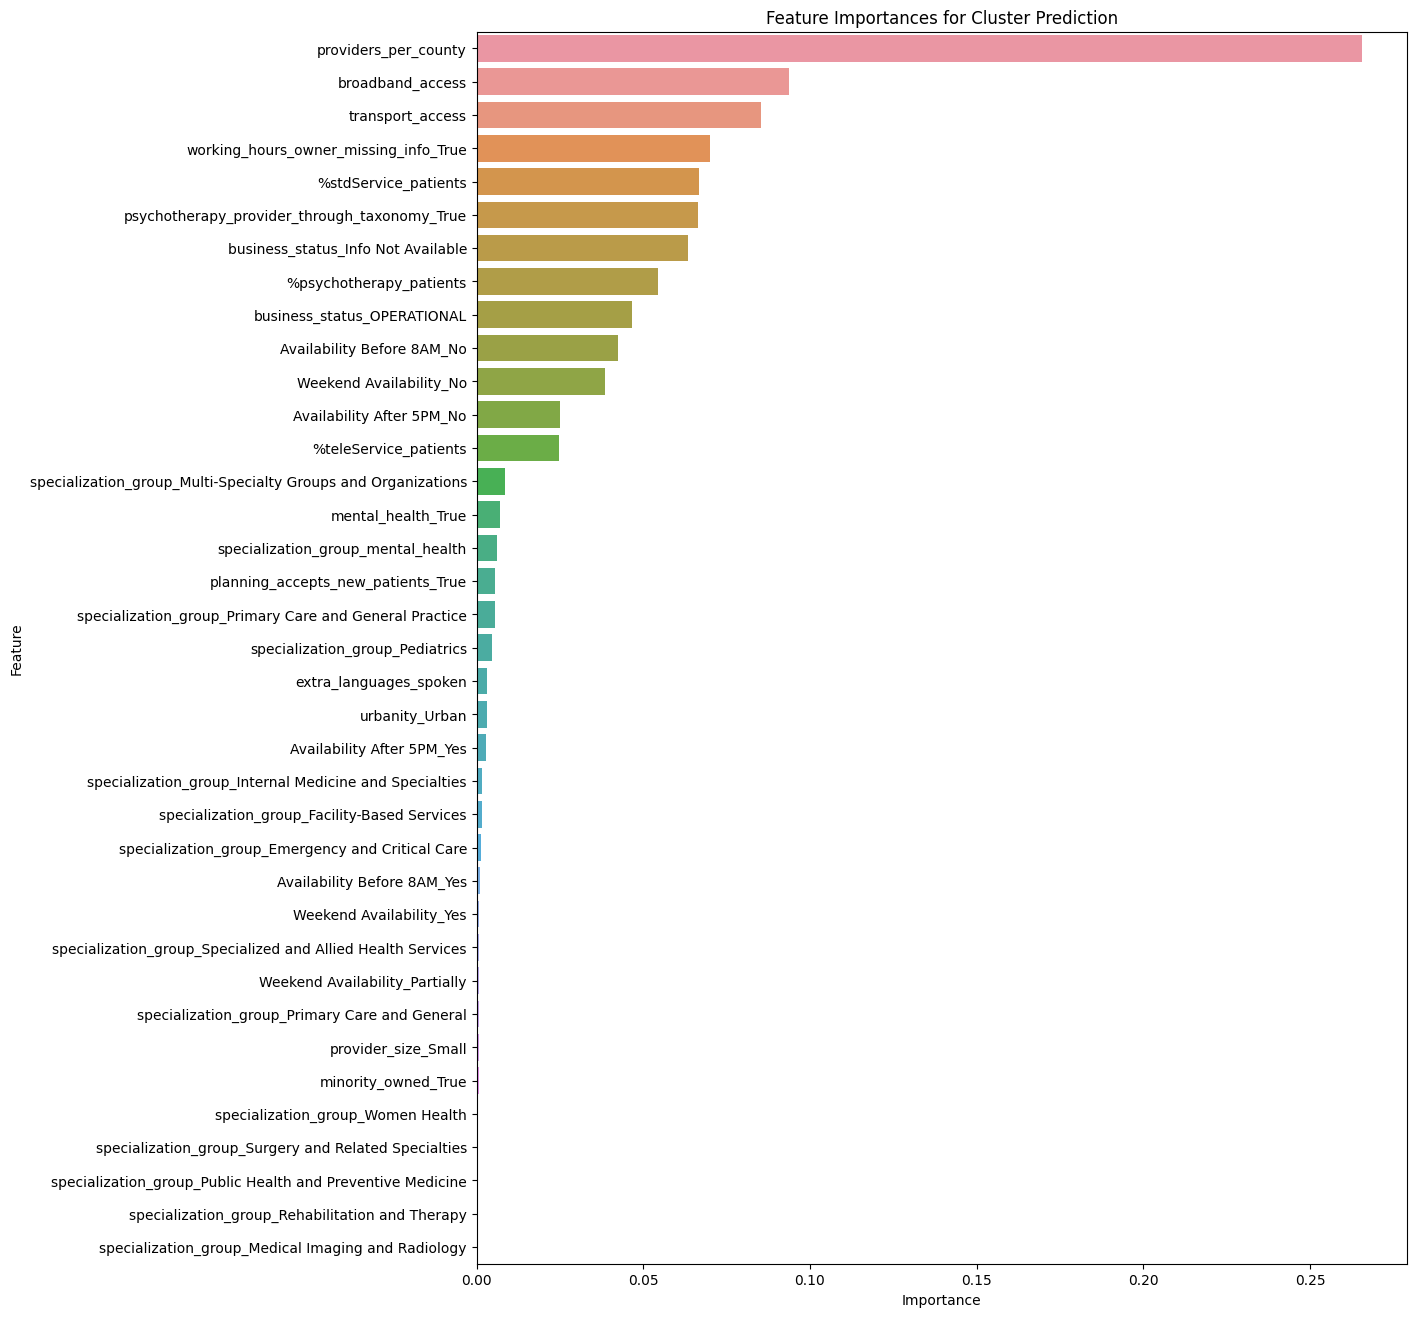

In [336]:
# creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering
# additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_df, cluster_df['agg_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_final_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 16))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

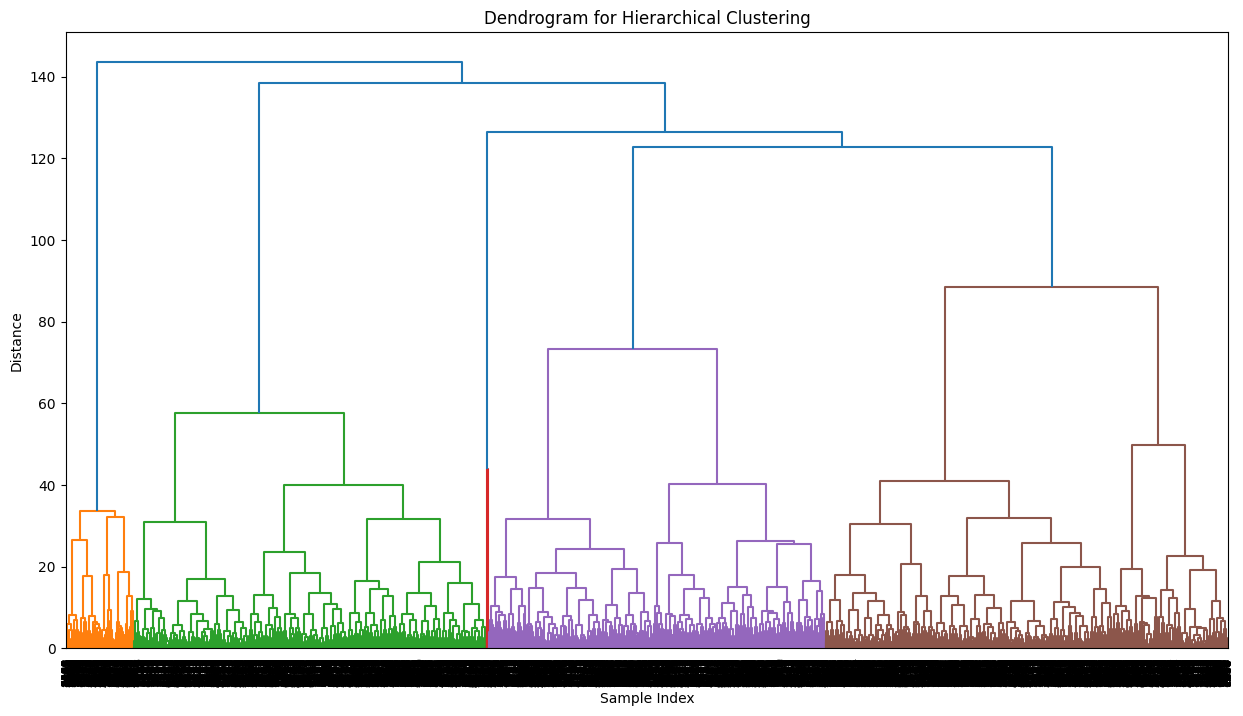

In [139]:
# visualizing the AgglomerativeClustering (hierarchical clustering) using a Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Plot the dendrogram
# Compute the linkage matrix using the 'ward' method
Z = linkage(X_final, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [341]:
cluster_df.drop(columns=['agg_cluster'], inplace=True)

# DBSCAN

In [140]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
X_final = X_final_df.to_numpy()
dbscan = DBSCAN(eps=1.5, min_samples=500)  # parameters
cluster_df['dbscan_cluster'] = dbscan.fit_predict(X_final)

# Check the clusters
print(cluster_df['dbscan_cluster'].value_counts())

dbscan_cluster
 0    4689
-1    4231
Name: count, dtype: int64


In [206]:
cluster_df.groupby('dbscan_cluster').mean()

,psychotherapy_provider_through_taxonomy_True,urbanity_Urban,provider_size_Small,planning_accepts_new_patients_True,business_status_Info Not Available,business_status_OPERATIONAL,Weekend Availability_No,Weekend Availability_Partially,Weekend Availability_Yes,Availability Before 8AM_No,Availability Before 8AM_Yes,Availability After 5PM_No,Availability After 5PM_Yes,mental_health_True,working_hours_owner_missing_info_True,minority_owned_True,standard_services_claims,tele_services_claims,total_psychotherapy_claims,transport_access,broadband_access,extra_languages_spoken,providers_per_county
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,,,
-1,0.528731,0.807734,0.966028,0.354174,0.290929,0.641489,0.611131,0.047705,0.050235,0.641489,0.067582,0.524033,0.185038,0.452837,0.290929,0.029274,0.140282,0.186891,0.181595,-0.485592,-0.541293,0.089062,0.166149
0,0.742249,0.883387,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450486,1.000000,0.000000,-0.057805,-0.065823,-0.057390,0.160711,0.208497,-0.040051,-0.298988
1,0.619614,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320951,1.000000,0.000000,-0.045577,-0.061934,-0.068193,0.218465,0.687577,-0.040051,1.908796
2,0.296200,0.934370,1.000000,0.634715,0.000000,0.969775,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.153713,0.000000,0.001727,-0.092966,-0.164905,-0.180085,0.433519,0.115625,-0.040051,-0.390438


In [ ]:
# plotting the above as a heatmap
grouped_means_db = cluster_df.groupby('agg_cluster').mean()

# each column is normalized independently to enable useful heatmap coloring
scaler = MinMaxScaler()
normalized_data_db = scaler.fit_transform(grouped_means_db)
normalized_df_db = pd.DataFrame(normalized_data_db, index=grouped_means_db.index, columns=grouped_means_db.columns)

# the heatmap is colored based on the normalized data but it is the "original" mean values that are shown
plt.figure(figsize=(22, 8))
sns.heatmap(normalized_df_db, cmap='coolwarm', annot=grouped_means_db, fmt=".2f")
plt.title('Cluster Mean Values Heatmap')
plt.show()

Random Forest Classifier Accuracy: 0.9995515695067264
              precision    recall  f1-score   support

          -1       1.00      0.88      0.93         8
           0       1.00      1.00      1.00      2222

    accuracy                           1.00      2230
   macro avg       1.00      0.94      0.97      2230
weighted avg       1.00      1.00      1.00      2230



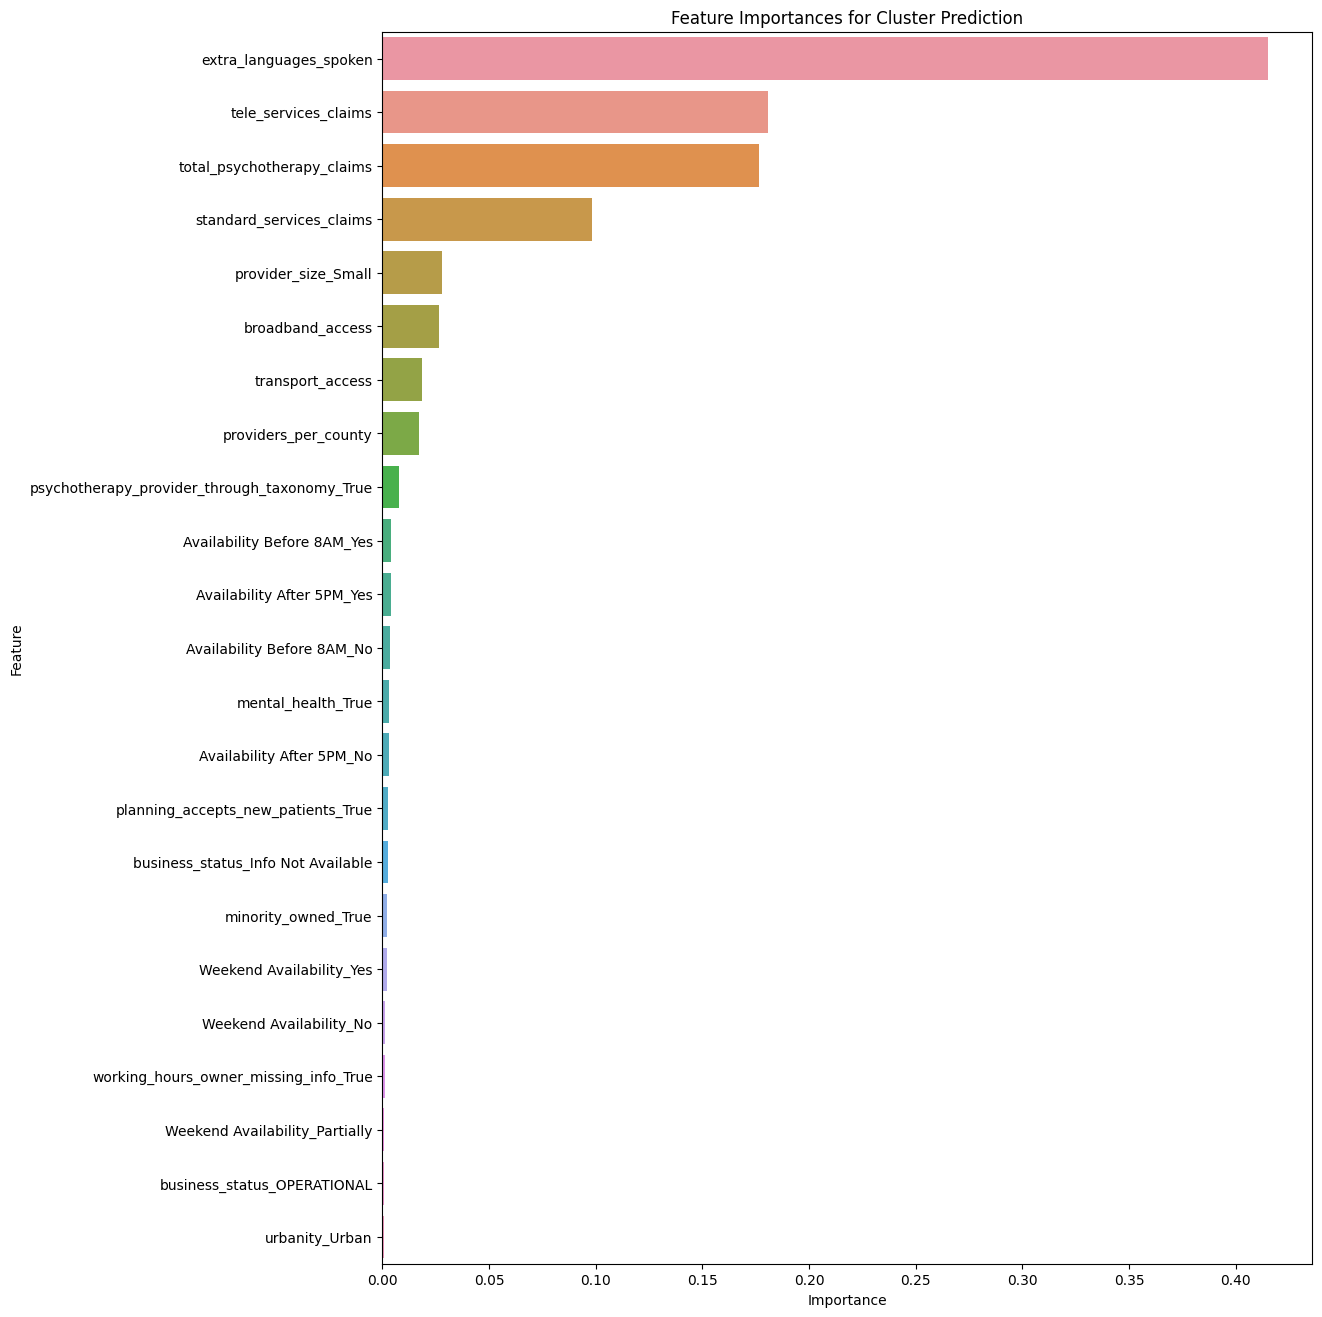

In [168]:
# creating a Random Forest classification model with the clusters as the target can yield insights regarding which features are most important for the clustering
# additionally, if the clusters can be predicted with a high accuracy by the RF model, it suggests that the clusters are well defined and distinguishable from each other

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(cluster_df.drop(columns='dbscan_cluster'), cluster_df['dbscan_cluster'], test_size=0.25, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the cluster labels for the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')

# Display classification report for detailed metrics
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': cluster_df.drop(columns='dbscan_cluster').columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 16))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for Cluster Prediction')
plt.show()

In [ ]:
X_final_df.drop(columns=['dbscan_cluster'], inplace=True)